# TP2 - MCMC

## Estimation avancée - G3 SDIA

Dans ce TP, on s'intéresse aux méthodes d'échantillonnage dites "MCMC" (Monte Carlo par Chaînes de Markov). Le premier exercice consiste à implémenter un Metropolis-Hastings et de regarder l'influence de quelques paramètres. Le deuxième exercice mettra en oeuvre une méthode de régression bayésienne linéaire (disponible dans un deuxième notebook).

### Instructions

1. Renommer votre notebook sous la forme `tp2a_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 10 Décembre 2023, 23h59.

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as ss

### Partie 1 - Metropolis-Hastings

Dans cet exercice, on cherche à générer des échantillons d'une loi appelée *skew-normal* (cf. [Wikipedia](https://en.wikipedia.org/wiki/Skew_normal_distribution)). C'est une loi à support sur $\mathbb{R}$ à trois paramètres : $\alpha \in \mathbb{R}$ (paramètre de skewness), $\xi \in \mathbb{R}$ (paramètre de position), et $\sigma > 0$ (paramètre d'échelle). Dans ce TP nous prendrons $\alpha = 4, \xi = 0, \sigma = 3$.

L'objectif est d'implémenter un algorithme Metropolis-Hastings (MH) avec une loi instrumentale Gaussienne $\mathcal{N}(x_n, \sigma_0^2)$ (i.e., centrée en l'état courant, de variance $\sigma_0^2$).

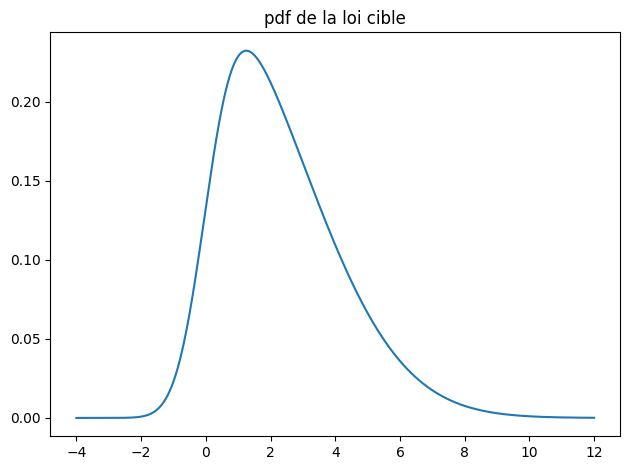

In [4]:
# pdf of the target distribution
a = 4
lc = 0
sc = 3
x = np.linspace(-4,12,500)
y = ss.skewnorm.pdf(x, a, loc=lc, scale=sc)
plt.plot(x,y)
plt.title('pdf de la loi cible')
plt.tight_layout()

**Q1.** Écrire une fonction qui implémente l'algorithme MH proposé, prenant comme arguments :
* La taille de la chaine N
* L'état initial $x_0$
* L'écart-type $\sigma_0$ de la *proposal* gaussienne
* Une graine aléatoire

Pensez à utiliser les fonctions implémentées dans `scipy.stats` pour les pdfs !

In [15]:
def metropolis_hastings(N, x0, s, seed=1234):
    x = x0
    X = [x]

    rng = np.random.default_rng(seed)
    for _ in range(N):
        x_new = np.random.normal(x,s)
        proba = ss.skewnorm.pdf(x_new, a, loc=lc, scale=sc)*ss.norm.pdf(x, loc=x_new,scale =s)/(ss.skewnorm.pdf(x, a, loc=lc, scale=sc)*ss.norm.pdf(x_new,loc=x,scale =s))
        alpha = min(1, proba)
        if rng.random() <= alpha:
            x = x_new
        X.append(x)

    return X

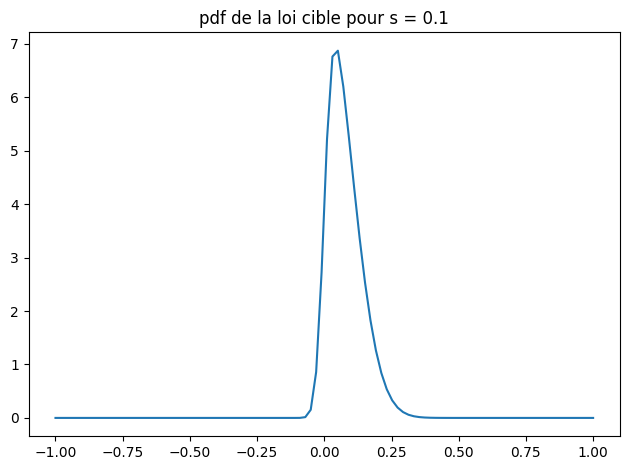

In [19]:
# pdf of the target distribution
a = 4
lc = 0
sc = 0.1
x = np.linspace(-1,1,100)
y = ss.skewnorm.pdf(x, a, loc=lc, scale=sc)
plt.plot(x,y)
plt.title('pdf de la loi cible pour s = 0.1')
plt.tight_layout()

On remarque que le support de la loi skew-norm est beaucoup plus restreint pour des valeurs de sigma faible

On peut également remarquer que les termes issues de la proposal dans le cadre d'une loi gaussienne sont les mêmes car l'expression est symétrique en x/mu, donc la proba devient 

$\text{proba} = \frac{\text{skewnorm.pdf}(x_{\text{new}}, a, \text{loc}=lc, \text{scale}=sc)}{\text{skewnorm.pdf}(x_{\text{old}}, a, \text{loc}=lc, \text{scale}=sc)}
$


**Q2**. Prendre $N = 1000, x_0 = 1$. Afficher les *traceplots* (échantillons en fonction de $n$) de la chaine pour des valeurs différentes de $\sigma$ : $0.1, 2, 40$.

Pour chacun des cas, comparer la pdf de la loi cible à une estimation par noyaux de la densité ou un histogramme. Commenter.

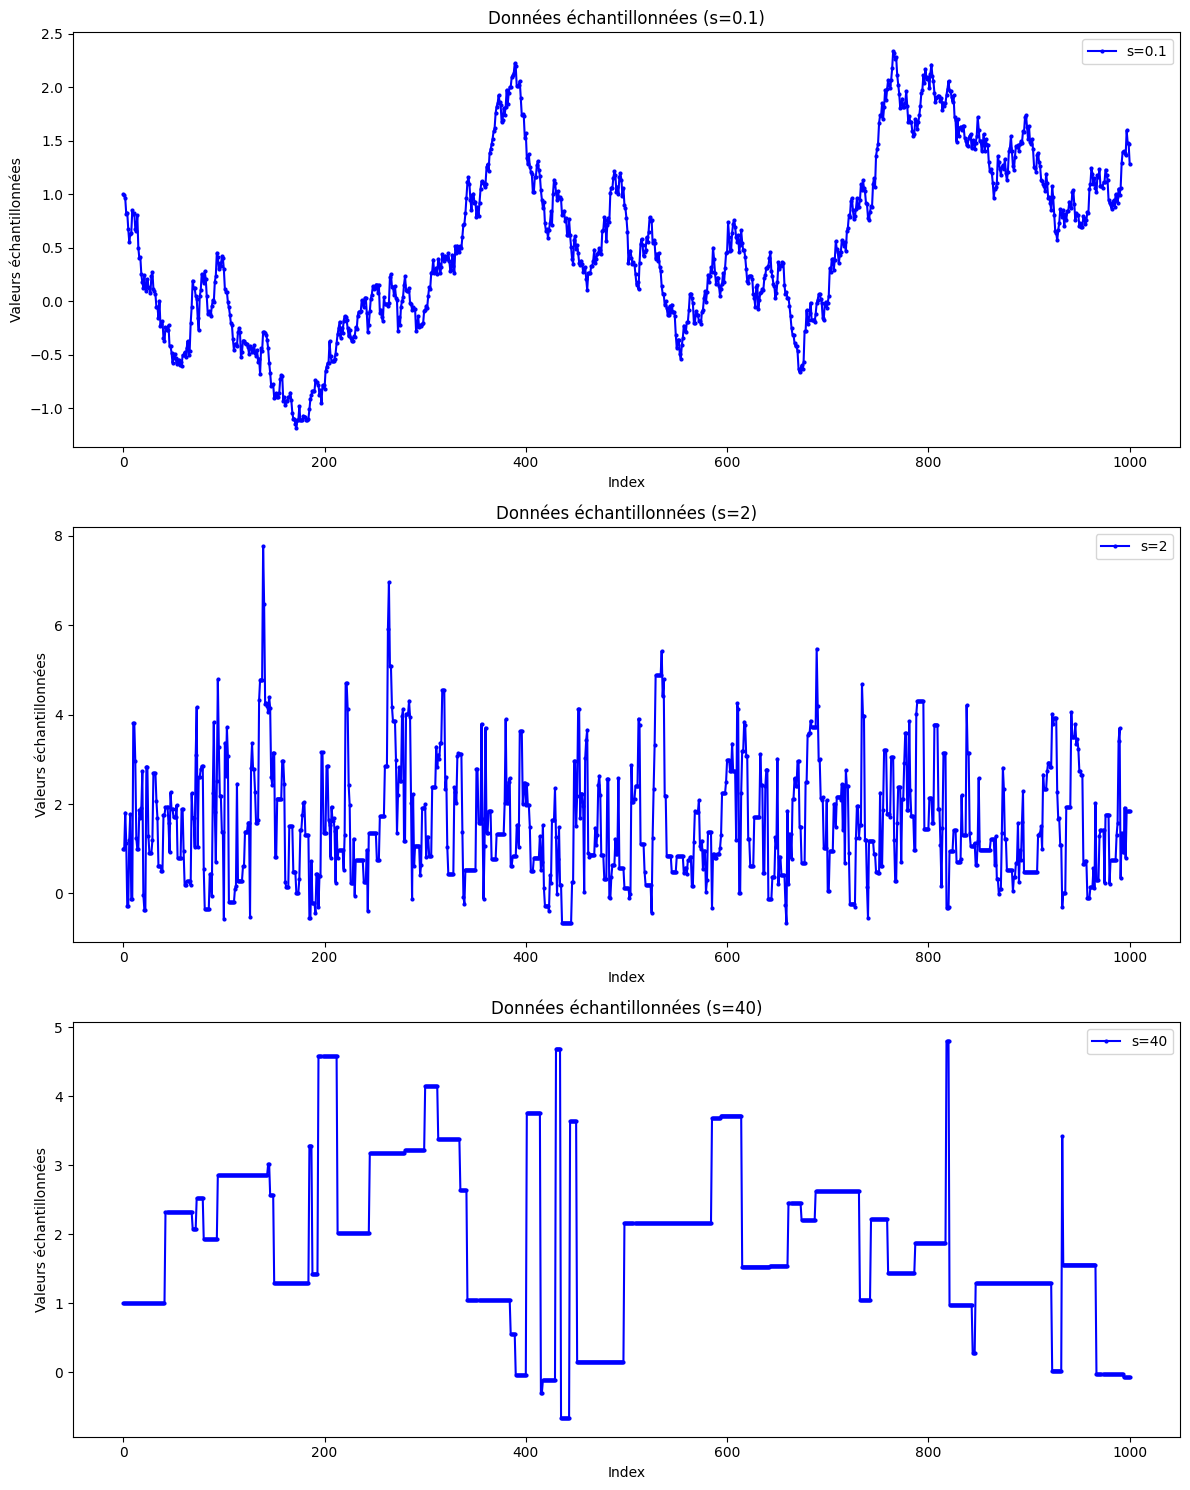

In [20]:
N = 1000
x0 = 1
s_tab = [0.1, 2, 40]


fig, axes = plt.subplots(3, figsize=(12, 15))
X_samples = []
for i, s in enumerate(s_tab):
    # Génération des données échantillonnées
    X_sampled = metropolis_hastings(N, x0, s)
    X_samples.append(X_sampled)
    
    # Tracé du graphique sur le sous-plot correspondant
    axes[i].plot(range(len(X_sampled)), X_sampled, linestyle='-', marker='o',markersize=2, color='blue', label=f's={s}')
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Valeurs échantillonnées')
    axes[i].set_title(f'Données échantillonnées (s={s})')
    axes[i].legend()

# Ajustement automatique de l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

On observe que pour sigma faible la chaine de markov explore un ensemble de valeurs restreint qui est logique étant donné qu'on a observé que le support de la distribution skewnorm est beaucoup plus petit pour des valeurs de sigma faible. A l'inverse pour des valeurs très élevé d'écart type la chaine de Markov ne change pas d'état régulièrement. pour une valeur intermédiaire on vsite fréquement des sites différents tout en atteignant la majorité du support de la distribution qu'on  cherche à sampler. 

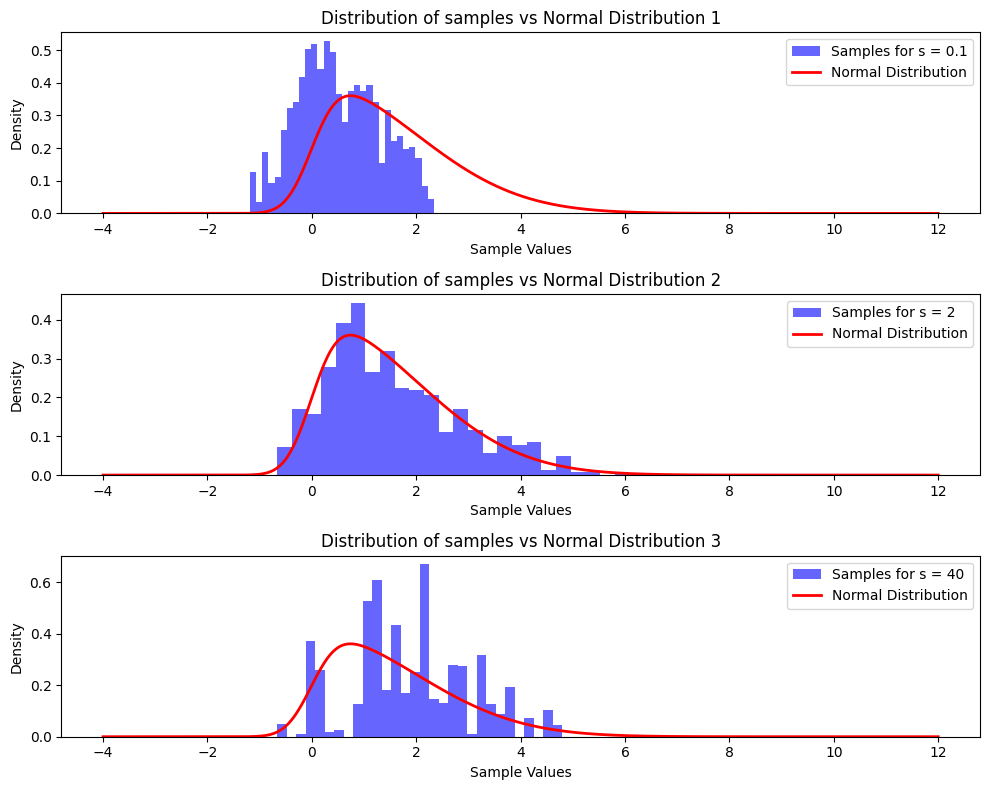

In [27]:
x = np.linspace(-4, 12, 500)
a, lc, sc = 5, 0, 2  # Paramètres pour la skewnorm
theoretical_density = ss.skewnorm.pdf(x, a, loc=lc, scale=sc)

fig, axes = plt.subplots(len(X_samples), figsize=(10, 8))

for i, samples in enumerate(X_samples):
    axes[i].hist(samples, bins=30, density=True, alpha=0.6, color='blue', label=f'Samples for s = {s_tab[i]}')
    axes[i].plot(x, theoretical_density, 'r', linewidth=2, label='Normal Distribution')
    
    axes[i].set_xlabel('Sample Values')
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Distribution of samples vs Normal Distribution {i+1}')
    axes[i].legend()

plt.tight_layout()
plt.show()


Nos impressions se confirment sur la comparaison de la distribution générés et la distribution thèorique, pour un écart-type faible on observe que la distribution est très concentré et n'atteint pas l'ensemble des valeurs du suport de la skewnorm, à l'inverse pour des valeurs élevé on a des pics éparpillés. Pour une valeur intermédiaire (s = 2) on otient un histogramme dont la distribution est proche de la distribution théorique

**Q3.** Prendre $N = 1000, s = 2$. Afficher les *traceplots* pour $x_0$ valant 0 et 50.

Pour chacun des cas, comparer la pdf de la loi cible à une estimation par noyaux de la densité ou un histogramme. Commenter.

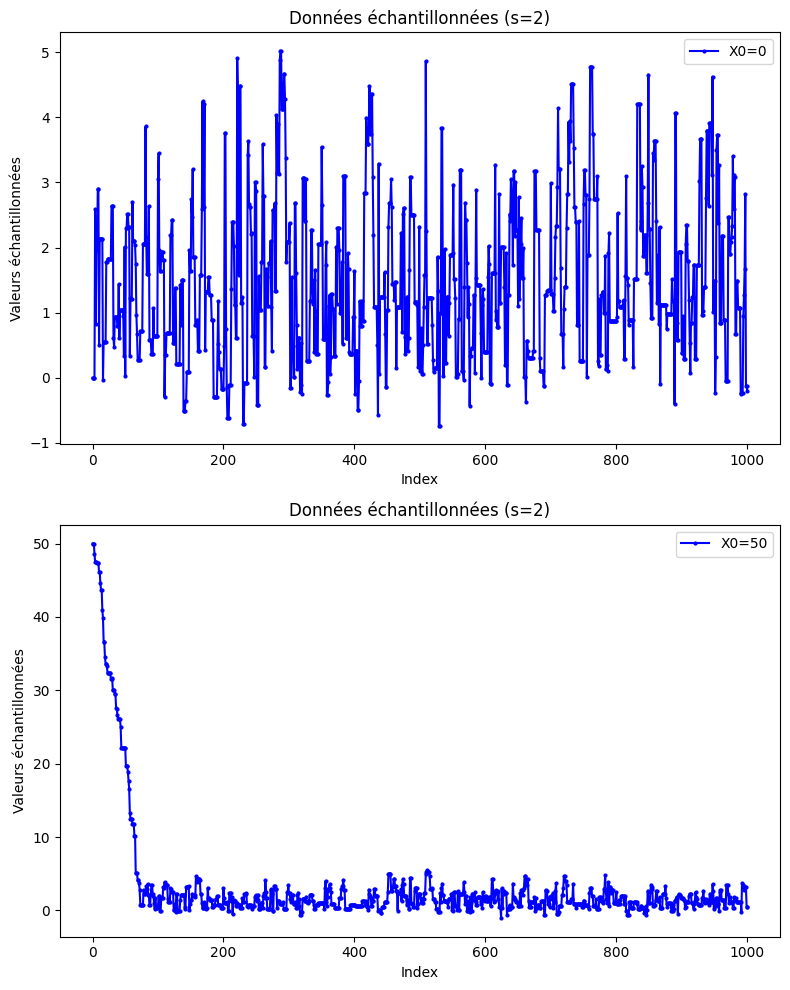

In [29]:
N = 1000
s = 2
x0_tab = [0, 50]


fig, axes = plt.subplots(2, figsize=(8, 10))
X_samples = []
for i, x0 in enumerate(x0_tab):
    # Génération des données échantillonnées
    X_sampled = metropolis_hastings(N, x0, s)
    X_samples.append(X_sampled)
    
    # Tracé du graphique sur le sous-plot correspondant
    axes[i].plot(range(len(X_sampled)), X_sampled, linestyle='-', marker='o',markersize=2, color='blue', label=f'X0={x0}')
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Valeurs échantillonnées')
    axes[i].set_title(f'Données échantillonnées (s={s})')
    axes[i].legend()

# Ajustement automatique de l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

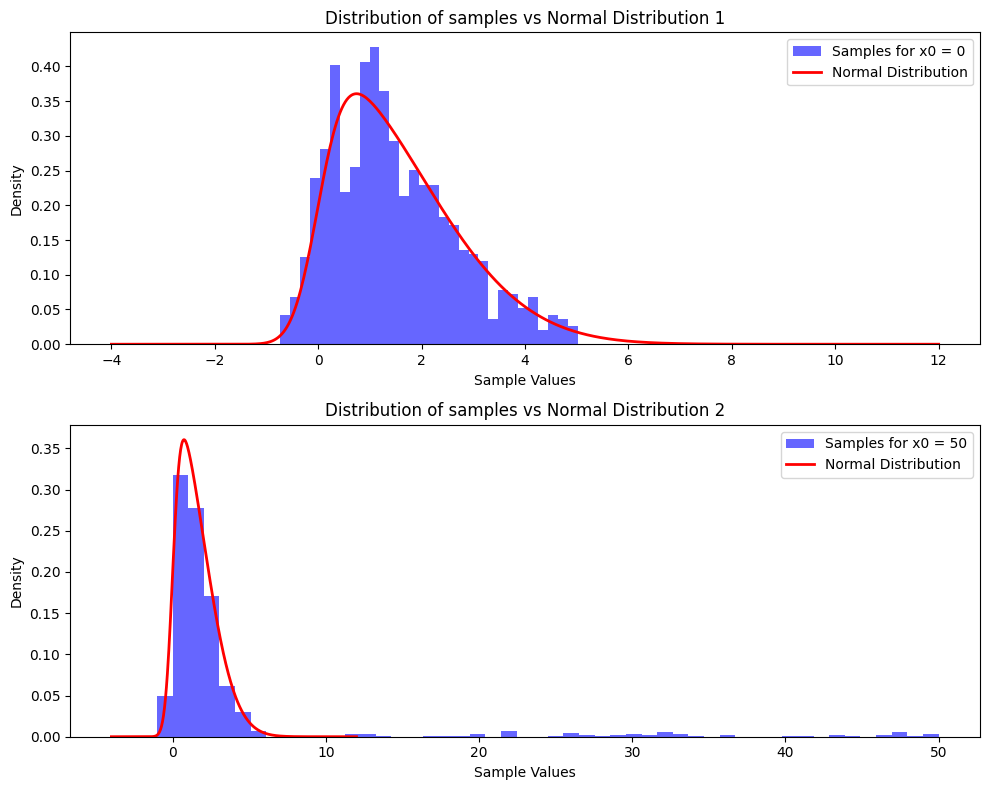

In [33]:
x = np.linspace(-4, 12, 500)
a, lc, sc = 5, 0, 2  # Paramètres pour la skewnorm
theoretical_density = ss.skewnorm.pdf(x, a, loc=lc, scale=sc)

fig, axes = plt.subplots(len(X_samples), figsize=(10, 8))
bins = [30,50]
for i, samples in enumerate(X_samples):
    axes[i].hist(samples, bins=bins[i], density=True, alpha=0.6, color='blue', label=f'Samples for x0 = {x0_tab[i]}')
    axes[i].plot(x, theoretical_density, 'r', linewidth=2, label='Normal Distribution')
    
    axes[i].set_xlabel('Sample Values')
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Distribution of samples vs Normal Distribution {i+1}')
    axes[i].legend()

plt.tight_layout()
plt.show()


Pour une valeur élevé d'initialisation, l'algorithme prend les bonnes décisions pour ramener dans le support de la distribution cible. 
En général on utilise une burn-in periode pour s'assurer que la chaine de markov se trouve bien dans le support de la distribution que l'on cherche à échantilloner  